In [1]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
import torch.nn as nn        #for all Neural Network stuff
import torch.optim as optim  #for all optimizer stuff

In [2]:
#method argument not needed??
data_size = 2000 #number of points in linspace
batch_time = 20 #number of points in the interval after a random starting point
batch_size = 500 #number of intervals
niters = 2000 #number of iterations
test_freq = 5
viz = True
gpu = 1
adjoint = True

In [3]:
from torchdiffeq import odeint_adjoint as odeint

In [4]:
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [5]:
#create linspace like usual
t = torch.linspace(0.0, 25.0, data_size)
g = 9.8
L1 = 1 
L2 = 0.75
m1 = 10
m2 = 10

In [6]:
def random():
    rand = 0
    while abs(rand) < 1 or abs(rand) > 3:
        rand = np.random.normal(0, 1, 1)[0]
    return rand

In [7]:
def getSlopesTorch(x,function):
    dim =  x.shape[0]**4
    slopeList = torch.zeros((dim,4))
    i = 0
    for f in x:
        for g in x:
            for h in x:
                for m in x:
                    #print(slope([],[f,g,h,m]))
                    slopeList[i] = function.forward([],torch.tensor([[f,g,h,m]]))
                    i += 1
    return slopeList

In [8]:
#lambda is a nn.Module like Linear, Conv2D etc,,
class Lambda(nn.Module):
    def forward(self,t,u):
        y = u[0]
        c, s = np.cos(y[0]-y[2]), np.sin(y[0]-y[2])
    
        de = torch.zeros_like(y)
        de[0] = y[1] #x1' = x2
        de[1] = (m2*g*np.sin(y[2])*c - m2*s*(L1*y[1]**2*c + L2*y[3]**2) - (m1 + m2)*g*np.sin(y[0]))/L1/(m1 + m2*s**2)
        de[2] = y[3] #y1' = y2
        de[3] = ((m1+m2)*(L1*y[1]**2*s - g*np.sin(y[2]) + g*np.sin(y[0])*c) + m2*L2*y[3]**2*s*c)/L2/(m1 + m2*s**2)

        return de

In [9]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
#s is a torch tensor from a numpy array. the array is a random choice array, a rand number from 0 to ds-bt is chosen bs times.
#s has batch_size elements and each was equally likely to be chosen
#why ds-bt? why not just data_size as a rance since we are chosing from the t linspace with ds many points?
#it does ds-bt so that when it chooses the next bt number of points we will never fall out of the index range if
#    ds=1000 and bt=10 then then if i start at 990, I will end up with 990-1000 and not over.
    batch_y0 = true_y[s] #(M, D) <- idk what this means
#b_y0 is made of the randomly selected data points (dep vals) from true_y solution
    batch_t = t[:batch_time] #(T)
#b_t is the values rank 0 to b_time from your linspace t; the linspace values being looked at
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [10]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [11]:
def visualize(solution):
    
    #Draw 
    theta1 = solution.numpy()[:,0,0]
    theta2 = solution.numpy()[:,0,2]
    x1_cor = 0
    y1_cor = 1

    x1 = L1 * np.sin(theta1) + x1_cor
    y1 = -L1 * np.cos(theta1) + y1_cor
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)

    plt.plot(x1,y1,'b',x2,y2,'g')

    plt.xlim(-2,2)
    plt.ylim(-1,3)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()

In [17]:
class ODEFunc(nn.Module): #create an ODE block as our neural network. usually multiple layers/modules
    
    def __init__(self):
        super(ODEFunc, self).__init__()
#self.net is the neural network layers one after the other L -> T -> L        
        self.net = nn.Sequential(    
            nn.Linear(4,50),
            nn.Tanh(),
            nn.Linear(50,100),
            nn.Tanh(),
            nn.Linear(100,50),
            nn.Tanh(),
            nn.Linear(50,4),
        )
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear): #checks in the module m in self.net is an instance of the nn.Linear class
                nn.init.normal_(m.weight, mean=0, std=0.1) #for the Linear modules make all the weights randn with std 0.1
                nn.init.constant_(m.bias, val=0) #for the Linear modules make all the bias vector values 0
    
    def forward(self, t, y):
        return self.net(y) #essentially Lambda.forward(args) without the true_A >>>which is TBD<<<

In [13]:
class RunningAverageMeter(object): #Computes and stores the average and current value
    def __init__(self, momentum=0.99): #new object of this class will have mom of 0.99 and a reset val and avg
        self.momentum = momentum
        self.reset()
    def reset(self):                   #reset function called to set val and avg to None and 0 respectively
        self.val = None
        self.avg = 0
    def update(self, val):             #update is called externally to update the avg based on val
        if self.val is None:
            self.avg = val
        else:
            self.avg = (self.avg * self.momentum) + (val * (1 - self.momentum)) #reminds me of output error at L

Iteration 0001 | Total Loss 466.404663
Iteration 0002 | Total Loss 779.643982
Iteration 0003 | Total Loss 1286.922607
Iteration 0004 | Total Loss 1298.742432
Iteration 0005 | Total Loss 687.840576


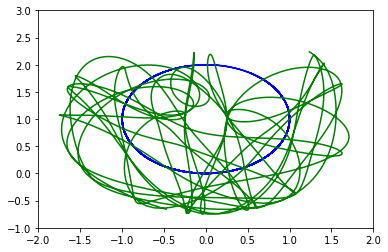

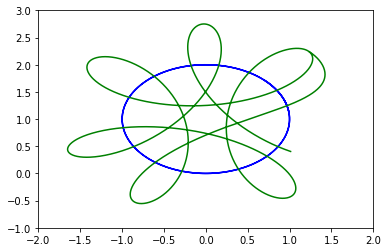

Iteration 0006 | Total Loss 187.387527
Iteration 0007 | Total Loss 247.825272
Iteration 0008 | Total Loss 197.924042
Iteration 0009 | Total Loss 108.773300
Iteration 0010 | Total Loss 63.206497


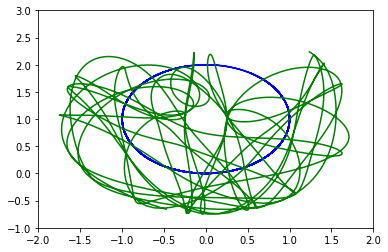

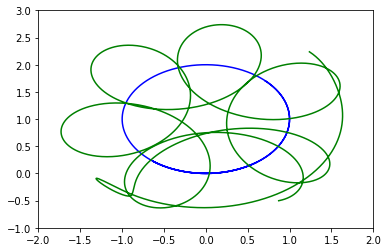

Iteration 0011 | Total Loss 51.224953
Iteration 0012 | Total Loss 46.695206
Iteration 0013 | Total Loss 43.337704
Iteration 0014 | Total Loss 40.279076
Iteration 0015 | Total Loss 37.539085


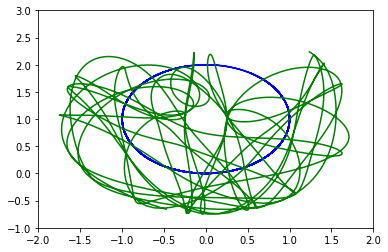

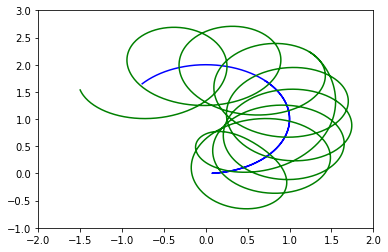

Iteration 0016 | Total Loss 35.675632
Iteration 0017 | Total Loss 35.732479
Iteration 0018 | Total Loss 36.286034
Iteration 0019 | Total Loss 37.626251
Iteration 0020 | Total Loss 33.348759


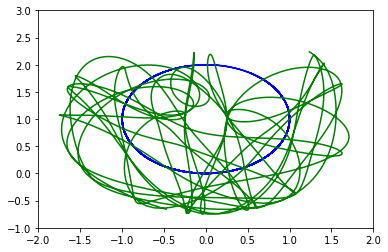

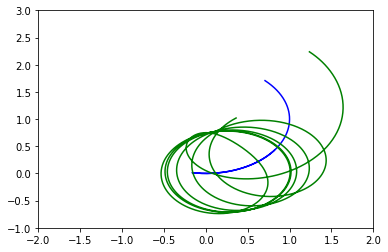

Iteration 0021 | Total Loss 30.135221
Iteration 0022 | Total Loss 28.380316
Iteration 0023 | Total Loss 27.346109
Iteration 0024 | Total Loss 26.628160
Iteration 0025 | Total Loss 26.182316


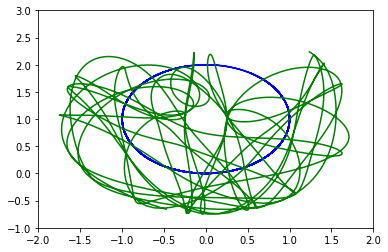

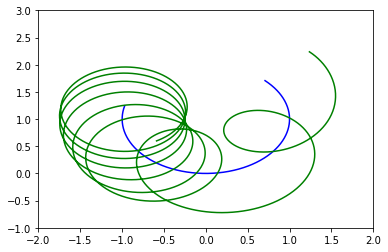

Iteration 0026 | Total Loss 28.539465
Iteration 0027 | Total Loss 64.055481
Iteration 0028 | Total Loss 129.056702
Iteration 0029 | Total Loss 52.189034
Iteration 0030 | Total Loss 152.765274


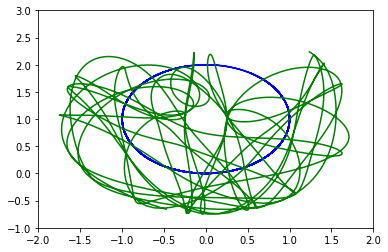

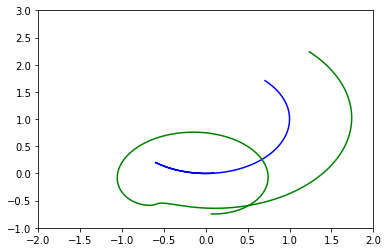

Iteration 0031 | Total Loss 40.144073
Iteration 0032 | Total Loss 34.998417
Iteration 0033 | Total Loss 34.249775
Iteration 0034 | Total Loss 30.999523
Iteration 0035 | Total Loss 29.507393


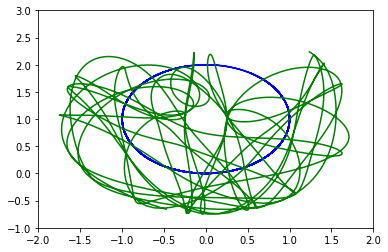

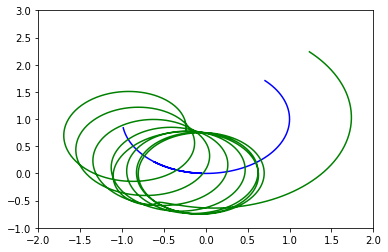

Iteration 0036 | Total Loss 29.019300
Iteration 0037 | Total Loss 28.649414
Iteration 0038 | Total Loss 28.329119
Iteration 0039 | Total Loss 28.037676
Iteration 0040 | Total Loss 27.765186


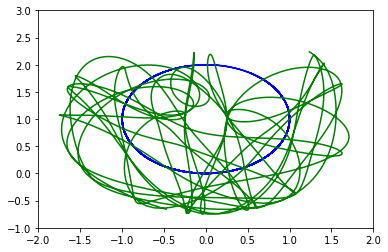

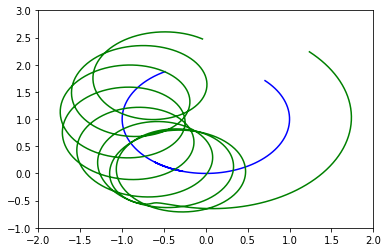

Iteration 0041 | Total Loss 27.505630
Iteration 0042 | Total Loss 27.254499
Iteration 0043 | Total Loss 27.007662
Iteration 0044 | Total Loss 26.760786
Iteration 0045 | Total Loss 26.508602


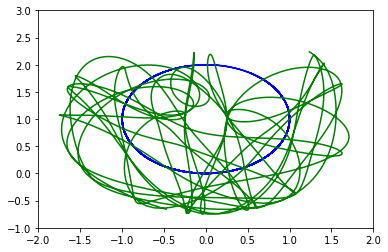

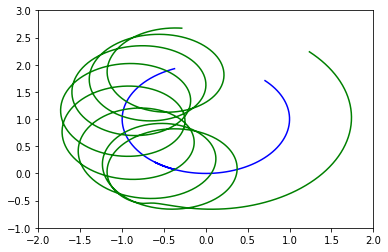

Iteration 0046 | Total Loss 26.244045
Iteration 0047 | Total Loss 25.957157
Iteration 0048 | Total Loss 25.634184
Iteration 0049 | Total Loss 25.259874
Iteration 0050 | Total Loss 24.828930


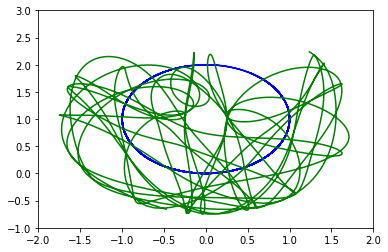

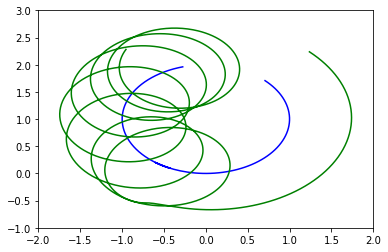

Iteration 0051 | Total Loss 24.359592
Iteration 0052 | Total Loss 23.878531
Iteration 0053 | Total Loss 23.395121
Iteration 0054 | Total Loss 22.932617
Iteration 0055 | Total Loss 22.590033


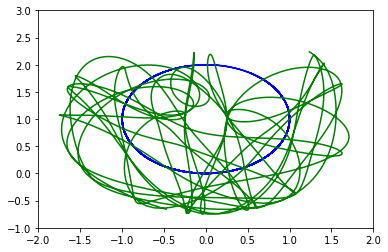

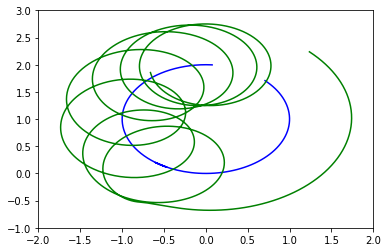

Iteration 0056 | Total Loss 24.030621
Iteration 0057 | Total Loss 49.444778
Iteration 0058 | Total Loss 76.782265
Iteration 0059 | Total Loss 37.972260
Iteration 0060 | Total Loss 29.466341


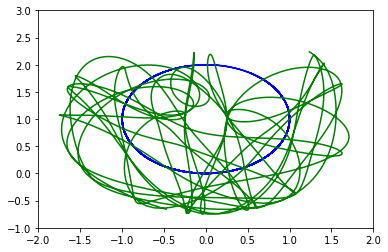

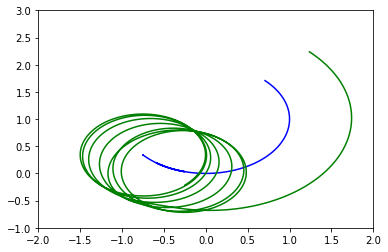

Iteration 0061 | Total Loss 26.968794
Iteration 0062 | Total Loss 26.262180
Iteration 0063 | Total Loss 25.757956
Iteration 0064 | Total Loss 25.264824
Iteration 0065 | Total Loss 24.737827


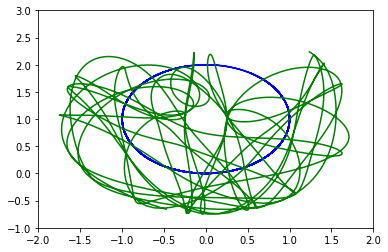

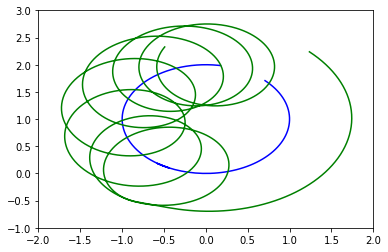

Iteration 0066 | Total Loss 24.160774
Iteration 0067 | Total Loss 23.534010
Iteration 0068 | Total Loss 22.877676
Iteration 0069 | Total Loss 22.224949
Iteration 0070 | Total Loss 21.627396


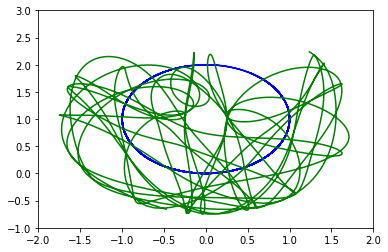

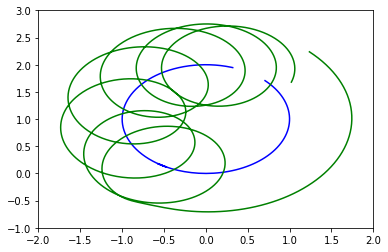

Iteration 0071 | Total Loss 21.129944
Iteration 0072 | Total Loss 21.054550
Iteration 0073 | Total Loss 27.610302
Iteration 0074 | Total Loss 78.454994
Iteration 0075 | Total Loss 64.419159


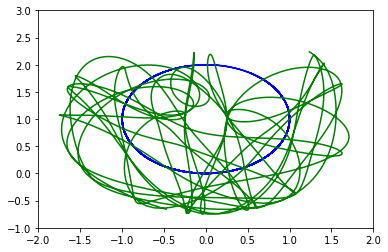

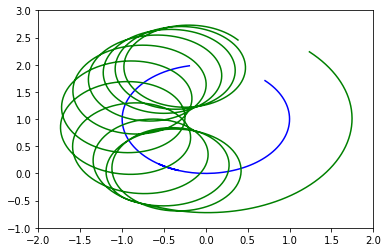

Iteration 0076 | Total Loss 39.927837
Iteration 0077 | Total Loss 26.558952
Iteration 0078 | Total Loss 25.468687
Iteration 0079 | Total Loss 24.834667
Iteration 0080 | Total Loss 24.362404


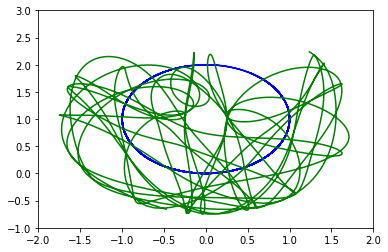

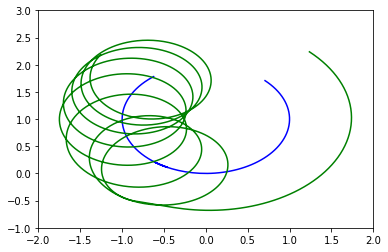

Iteration 0081 | Total Loss 23.956139
Iteration 0082 | Total Loss 23.582676
Iteration 0083 | Total Loss 23.228519
Iteration 0084 | Total Loss 22.887718
Iteration 0085 | Total Loss 22.559500


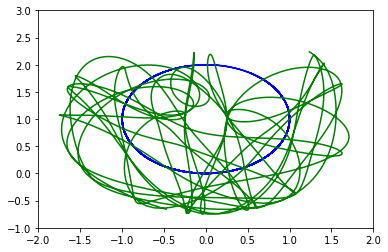

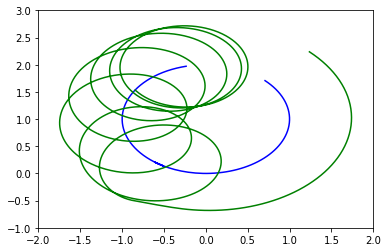

Iteration 0086 | Total Loss 22.245705
Iteration 0087 | Total Loss 21.947083
Iteration 0088 | Total Loss 21.660816
Iteration 0089 | Total Loss 21.382397
Iteration 0090 | Total Loss 21.107531


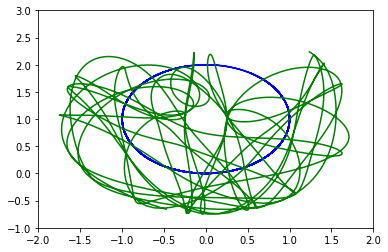

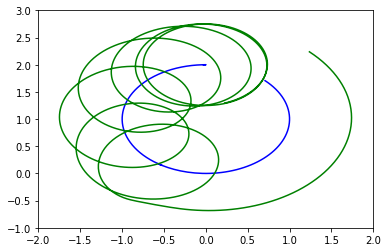

Iteration 0091 | Total Loss 20.832125
Iteration 0092 | Total Loss 20.552128
Iteration 0093 | Total Loss 20.266062
Iteration 0094 | Total Loss 19.981678
Iteration 0095 | Total Loss 19.717257


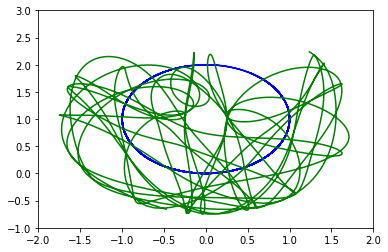

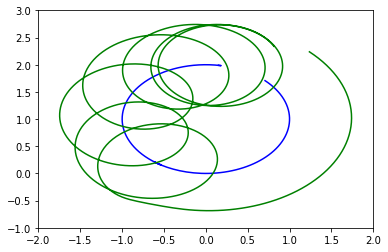

Iteration 0096 | Total Loss 19.519258
Iteration 0097 | Total Loss 19.885960
Iteration 0098 | Total Loss 28.459473
Iteration 0099 | Total Loss 70.691795
Iteration 0100 | Total Loss 64.808739


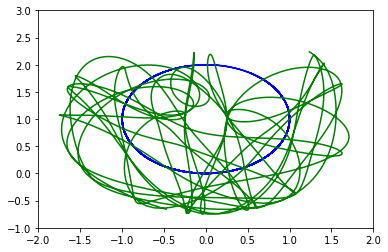

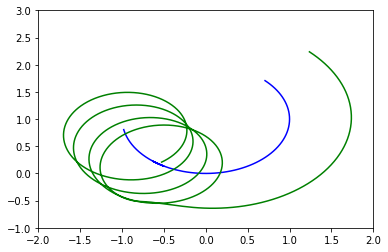

Iteration 0101 | Total Loss 30.855972
Iteration 0102 | Total Loss 27.126951
Iteration 0103 | Total Loss 25.049864
Iteration 0104 | Total Loss 24.134964
Iteration 0105 | Total Loss 23.603981


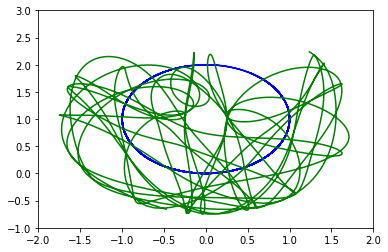

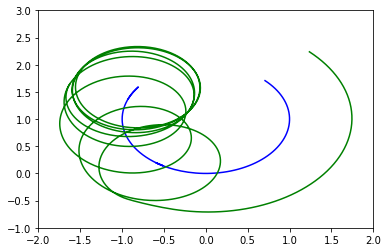

Iteration 0106 | Total Loss 23.211493
Iteration 0107 | Total Loss 22.891403
Iteration 0108 | Total Loss 22.608719
Iteration 0109 | Total Loss 22.342890
Iteration 0110 | Total Loss 22.083294


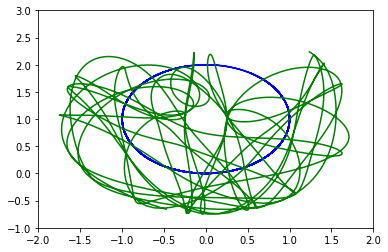

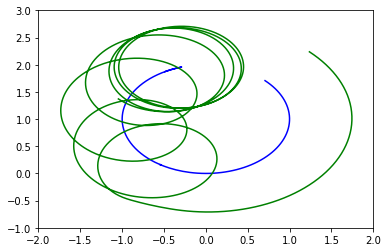

Iteration 0111 | Total Loss 21.823355
Iteration 0112 | Total Loss 21.560104
Iteration 0113 | Total Loss 21.291954
Iteration 0114 | Total Loss 21.052719
Iteration 0115 | Total Loss 21.059341


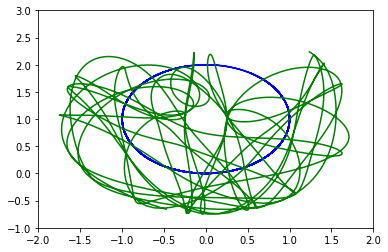

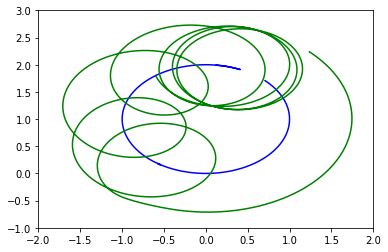

Iteration 0116 | Total Loss 23.862841
Iteration 0117 | Total Loss 35.176540
Iteration 0118 | Total Loss 51.770851
Iteration 0119 | Total Loss 34.678696
Iteration 0120 | Total Loss 26.908222


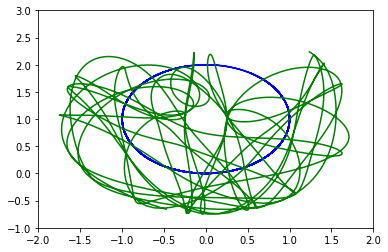

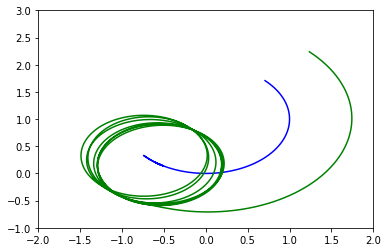

Iteration 0121 | Total Loss 24.410362
Iteration 0122 | Total Loss 23.424723
Iteration 0123 | Total Loss 22.813614
Iteration 0124 | Total Loss 22.377514
Iteration 0125 | Total Loss 22.028828


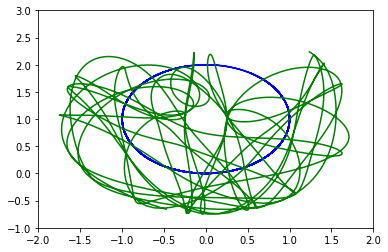

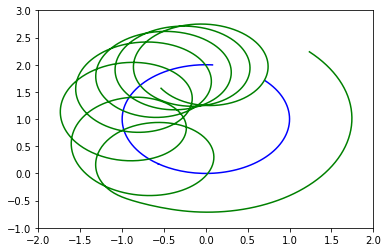

Iteration 0126 | Total Loss 21.724712
Iteration 0127 | Total Loss 21.445120
Iteration 0128 | Total Loss 21.179632
Iteration 0129 | Total Loss 20.921682
Iteration 0130 | Total Loss 20.665489


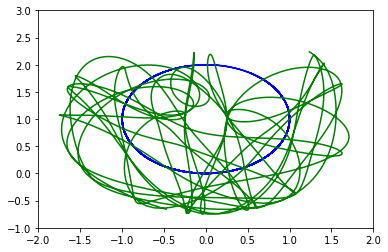

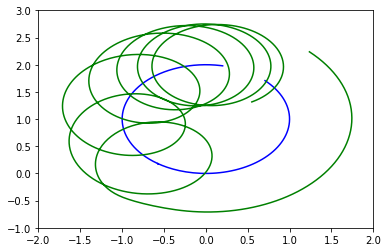

Iteration 0131 | Total Loss 20.405485
Iteration 0132 | Total Loss 20.138426
Iteration 0133 | Total Loss 19.867502
Iteration 0134 | Total Loss 19.614742
Iteration 0135 | Total Loss 19.418535


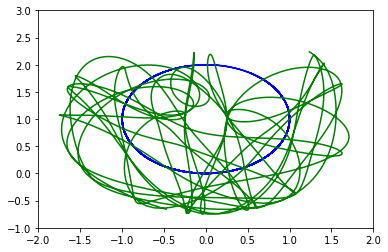

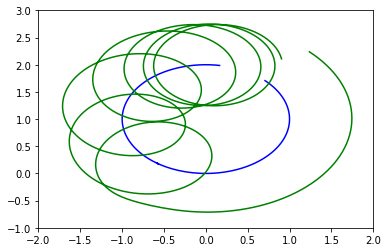

Iteration 0136 | Total Loss 19.493643
Iteration 0137 | Total Loss 23.030378
Iteration 0138 | Total Loss 49.718800
Iteration 0139 | Total Loss 33.279530
Iteration 0140 | Total Loss 41.770657


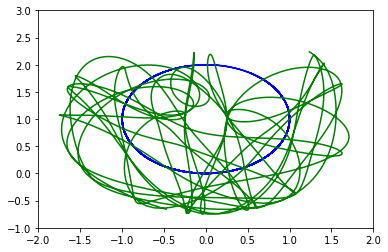

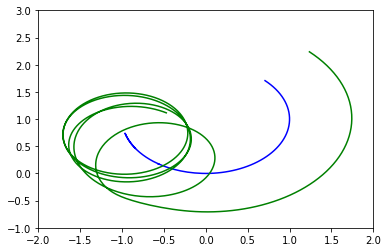

Iteration 0141 | Total Loss 22.847723
Iteration 0142 | Total Loss 21.292021
Iteration 0143 | Total Loss 20.750887
Iteration 0144 | Total Loss 20.433369
Iteration 0145 | Total Loss 20.176003


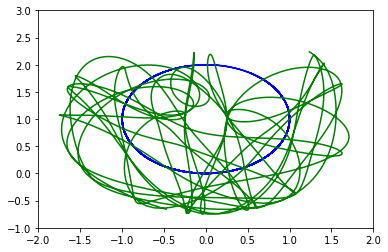

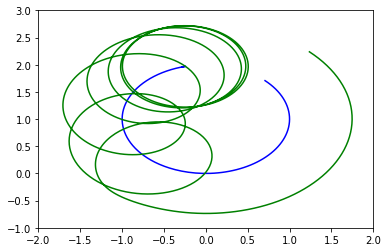

Iteration 0146 | Total Loss 19.947002
Iteration 0147 | Total Loss 19.739801
Iteration 0148 | Total Loss 19.552652
Iteration 0149 | Total Loss 19.385567
Iteration 0150 | Total Loss 19.237118


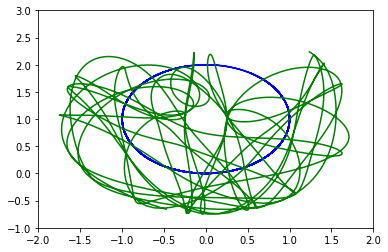

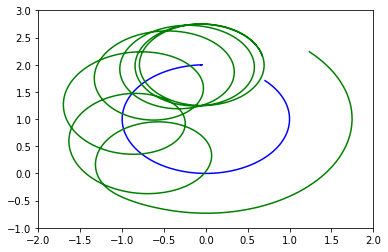

Iteration 0151 | Total Loss 19.106199
Iteration 0152 | Total Loss 18.990492
Iteration 0153 | Total Loss 18.889257
Iteration 0154 | Total Loss 18.801785
Iteration 0155 | Total Loss 18.734463


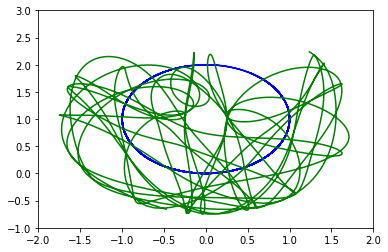

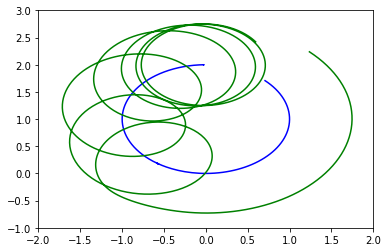

Iteration 0156 | Total Loss 18.715343
Iteration 0157 | Total Loss 18.866356
Iteration 0158 | Total Loss 19.892275
Iteration 0159 | Total Loss 23.273546
Iteration 0160 | Total Loss 37.581913


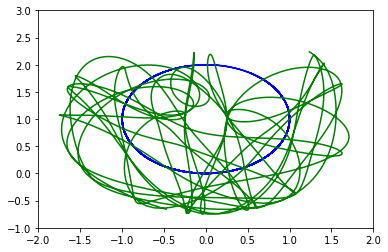

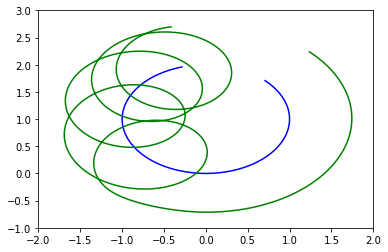

Iteration 0161 | Total Loss 26.696594
Iteration 0162 | Total Loss 28.045668
Iteration 0163 | Total Loss 22.507231
Iteration 0164 | Total Loss 22.799828
Iteration 0165 | Total Loss 20.217403


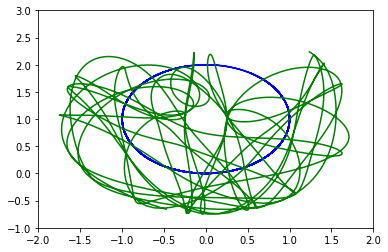

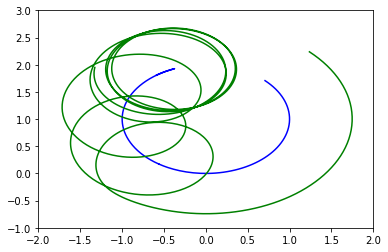

Iteration 0166 | Total Loss 19.772011
Iteration 0167 | Total Loss 19.418659
Iteration 0168 | Total Loss 19.276993
Iteration 0169 | Total Loss 19.135653
Iteration 0170 | Total Loss 19.082504


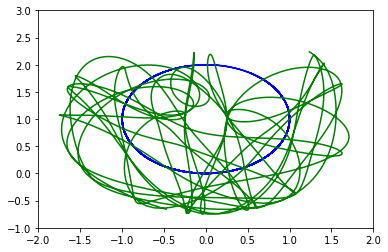

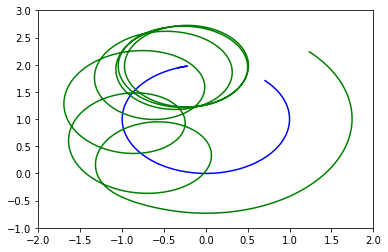

Iteration 0171 | Total Loss 19.029177
Iteration 0172 | Total Loss 19.120258
Iteration 0173 | Total Loss 19.225801
Iteration 0174 | Total Loss 19.861752
Iteration 0175 | Total Loss 20.347765


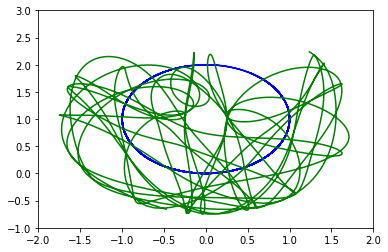

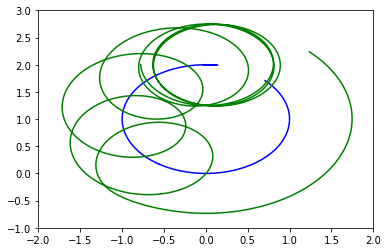

Iteration 0176 | Total Loss 22.970068
Iteration 0177 | Total Loss 22.280346
Iteration 0178 | Total Loss 25.633345
Iteration 0179 | Total Loss 21.665356
Iteration 0180 | Total Loss 22.027845


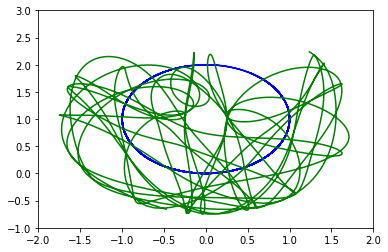

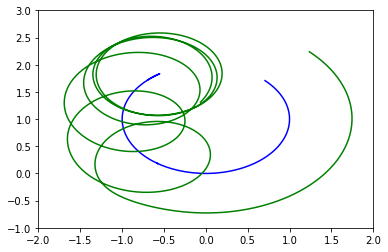

Iteration 0181 | Total Loss 20.239742
Iteration 0182 | Total Loss 20.258245
Iteration 0183 | Total Loss 19.618605
Iteration 0184 | Total Loss 19.712626
Iteration 0185 | Total Loss 19.437485


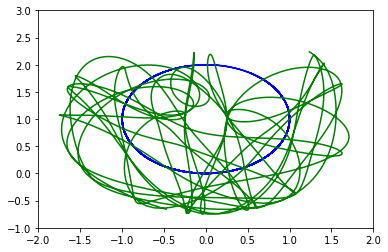

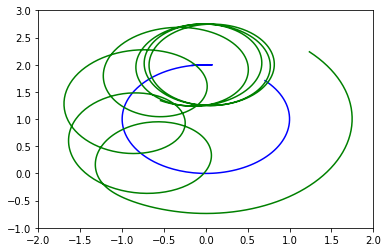

Iteration 0186 | Total Loss 19.709021
Iteration 0187 | Total Loss 19.582203
Iteration 0188 | Total Loss 20.219585
Iteration 0189 | Total Loss 20.119722
Iteration 0190 | Total Loss 21.404724


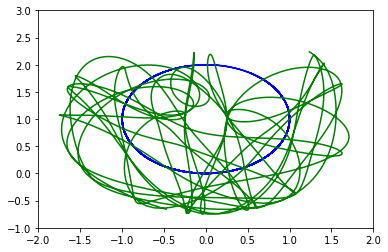

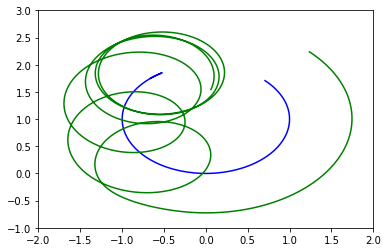

Iteration 0191 | Total Loss 20.882389
Iteration 0192 | Total Loss 22.532297
Iteration 0193 | Total Loss 21.060162
Iteration 0194 | Total Loss 22.056599
Iteration 0195 | Total Loss 20.501823


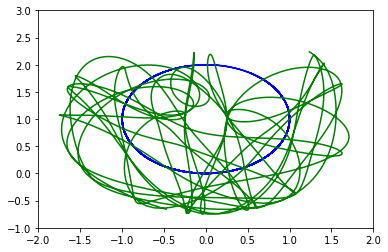

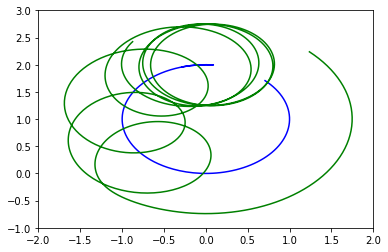

Iteration 0196 | Total Loss 20.889708
Iteration 0197 | Total Loss 19.950230
Iteration 0198 | Total Loss 20.214128
Iteration 0199 | Total Loss 19.686884
Iteration 0200 | Total Loss 20.030758


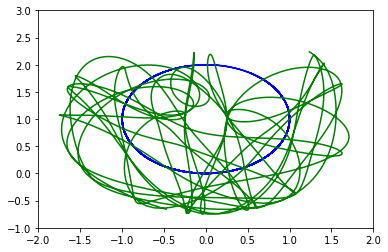

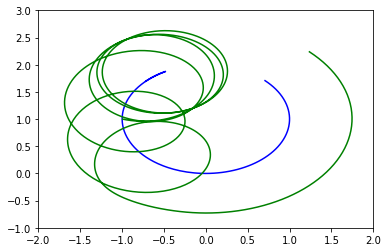

Iteration 0201 | Total Loss 19.694006
Iteration 0202 | Total Loss 20.244379
Iteration 0203 | Total Loss 19.953550
Iteration 0204 | Total Loss 20.826138
Iteration 0205 | Total Loss 20.375574


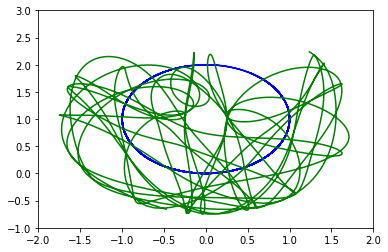

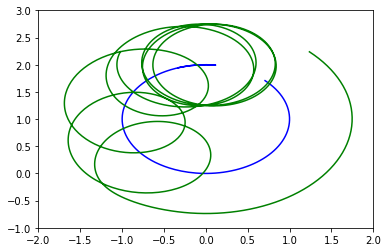

Iteration 0206 | Total Loss 21.496698
Iteration 0207 | Total Loss 20.635254
Iteration 0208 | Total Loss 21.606533
Iteration 0209 | Total Loss 20.476467
Iteration 0210 | Total Loss 21.083366


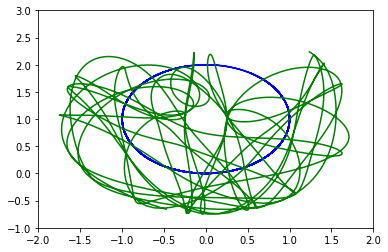

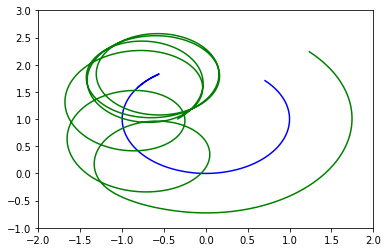

Iteration 0211 | Total Loss 20.125736
Iteration 0212 | Total Loss 20.549152
Iteration 0213 | Total Loss 19.878305
Iteration 0214 | Total Loss 20.310598
Iteration 0215 | Total Loss 19.825594


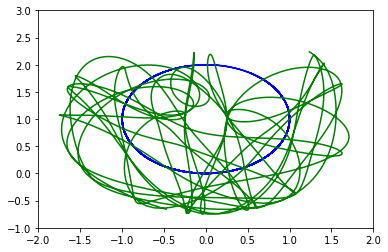

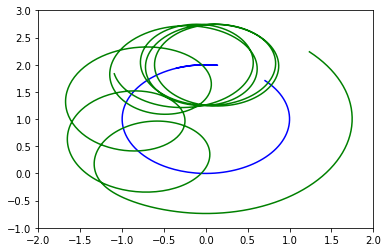

Iteration 0216 | Total Loss 20.385502
Iteration 0217 | Total Loss 19.966909
Iteration 0218 | Total Loss 20.730173
Iteration 0219 | Total Loss 20.234756
Iteration 0220 | Total Loss 21.166046


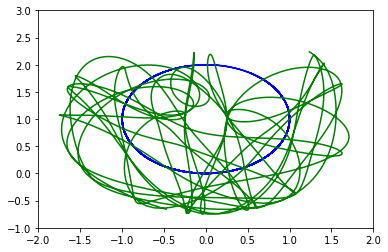

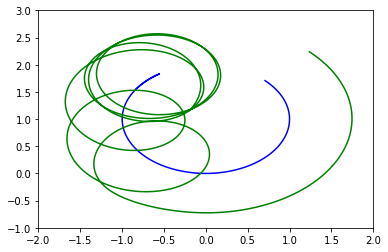

Iteration 0221 | Total Loss 20.443186
Iteration 0222 | Total Loss 21.338387
Iteration 0223 | Total Loss 20.408766
Iteration 0224 | Total Loss 21.098055
Iteration 0225 | Total Loss 20.195604


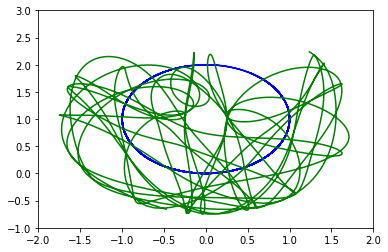

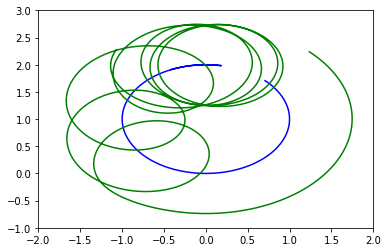

Iteration 0226 | Total Loss 20.733294
Iteration 0227 | Total Loss 19.999815
Iteration 0228 | Total Loss 20.519348
Iteration 0229 | Total Loss 19.932070
Iteration 0230 | Total Loss 20.532444


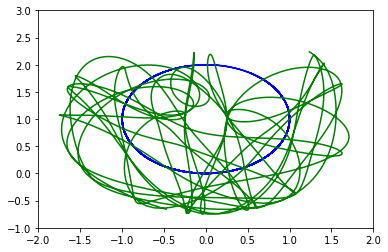

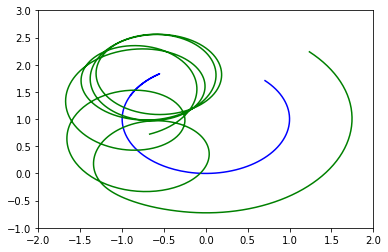

Iteration 0231 | Total Loss 20.014055
Iteration 0232 | Total Loss 20.754049
Iteration 0233 | Total Loss 20.194281
Iteration 0234 | Total Loss 21.046812
Iteration 0235 | Total Loss 20.341635


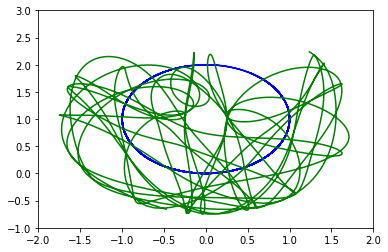

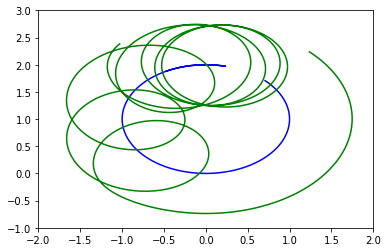

Iteration 0236 | Total Loss 21.179676
Iteration 0237 | Total Loss 20.331520
Iteration 0238 | Total Loss 21.043230
Iteration 0239 | Total Loss 20.190380
Iteration 0240 | Total Loss 20.798952


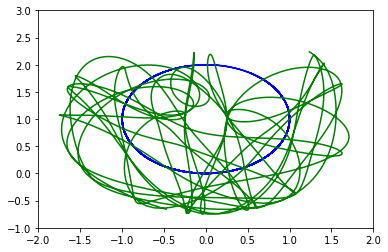

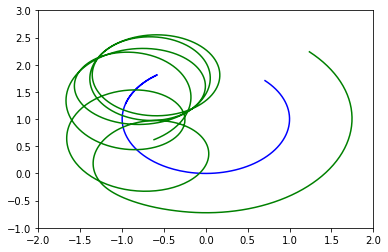

Iteration 0241 | Total Loss 20.047430
Iteration 0242 | Total Loss 20.640833
Iteration 0243 | Total Loss 19.996943
Iteration 0244 | Total Loss 20.653772
Iteration 0245 | Total Loss 20.059008


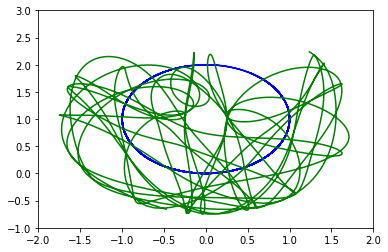

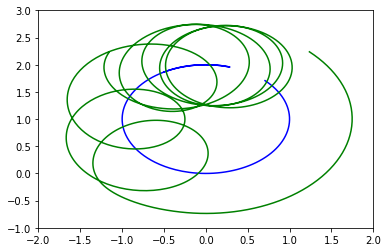

Iteration 0246 | Total Loss 20.816774
Iteration 0247 | Total Loss 20.189274
Iteration 0248 | Total Loss 21.019505
Iteration 0249 | Total Loss 20.281593
Iteration 0250 | Total Loss 21.090324


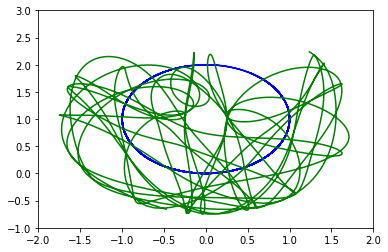

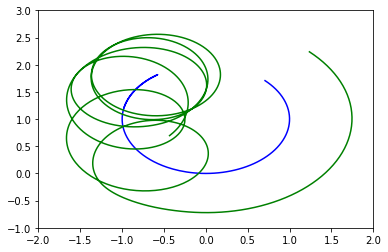

Iteration 0251 | Total Loss 20.257118
Iteration 0252 | Total Loss 20.981012
Iteration 0253 | Total Loss 20.142765
Iteration 0254 | Total Loss 20.802868
Iteration 0255 | Total Loss 20.040852


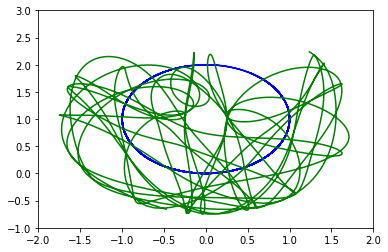

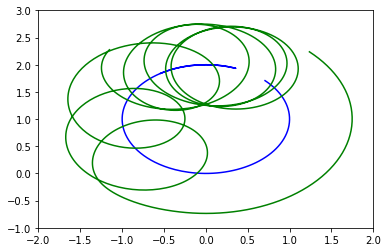

Iteration 0256 | Total Loss 20.706852
Iteration 0257 | Total Loss 20.016769
Iteration 0258 | Total Loss 20.739824
Iteration 0259 | Total Loss 20.086014
Iteration 0260 | Total Loss 20.894577


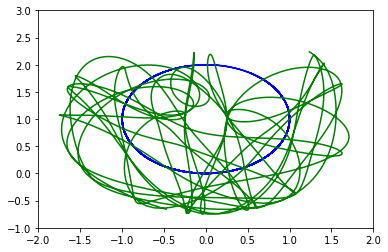

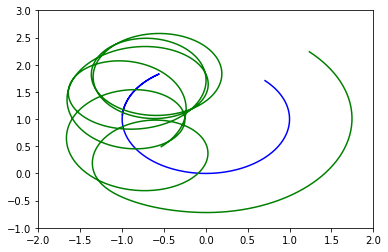

Iteration 0261 | Total Loss 20.182997
Iteration 0262 | Total Loss 21.023058
Iteration 0263 | Total Loss 20.229183
Iteration 0264 | Total Loss 21.048935
Iteration 0265 | Total Loss 20.148558


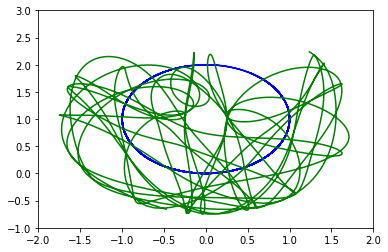

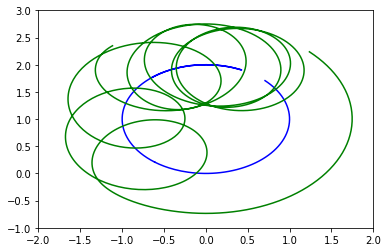

Iteration 0266 | Total Loss 20.874102
Iteration 0267 | Total Loss 20.071457
Iteration 0268 | Total Loss 20.842226
Iteration 0269 | Total Loss 19.935146
Iteration 0270 | Total Loss 20.598717


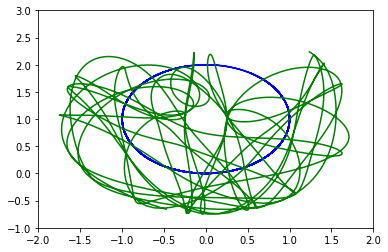

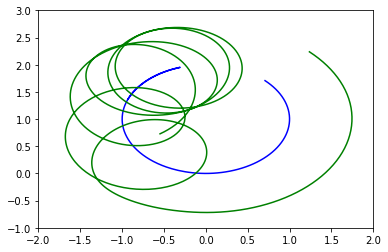

Iteration 0271 | Total Loss 20.120382
Iteration 0272 | Total Loss 21.110834
Iteration 0273 | Total Loss 20.026541
Iteration 0274 | Total Loss 20.818699
Iteration 0275 | Total Loss 20.303974


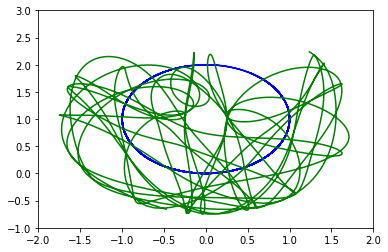

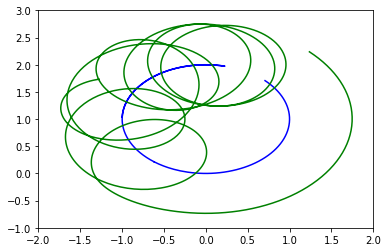

Iteration 0276 | Total Loss 21.002472
Iteration 0277 | Total Loss 20.059105
Iteration 0278 | Total Loss 20.255699
Iteration 0279 | Total Loss 19.353415


In [ ]:
if __name__ == '__main__':
    
    #ii = 0
    X = torch.linspace(-2,2,10)
    
    func = ODEFunc()
    optimizer = optim.RMSprop(func.parameters())          #this is an optimizer designed to update parameters
    end = time.time()                                     #usually people use SGD but this is a mini-batch approach
                                                          #http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    #RunningAvgMeter Objects
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    #initial conditions; requires 2D tensor
    true_y0 = torch.tensor([[3*np.pi/4, 0, 3*np.pi/4, 0]])

    with torch.no_grad(): #no_grad disables gradient finding when true_y is defined
        #print(torch.mm(true_y0**3,true_A))
        true_y = odeint(Lambda(),true_y0, t, method='adams') 
        #true_y is the solved ODE defined in Lambda
        #odeint only takes a function from nn.Module >> implications? see solver comparision Jupyter
        #it uses Lambda to provide the function to go solve the IVP given true_y0 with the ODE solver on t
        #trueSl = getSlopesTorch(X.numpy(),Lambda())
            
    #TRAINING
    for itr in range(1, niters+1):
        optimizer.zero_grad() #set gradients to zero/ not computed
        
        #batch_y0, batch_t, batch_y = get_batch()
        #feeds odeint the ODEBlock, a set of y values based on random t values and the first ten values of t
        pred_y = odeint(func, true_y0, t, method='adams')
        #deviates from usual Loss of mean squared difference but sum in both cases is positive
        #print(pred_y.detach(),batch_y)
        #---------------------------------------
        #predSl = getSlopesTorch(X.numpy(),func)
        
        loss = torch.mean(torch.abs(pred_y-true_y)**2) #ask Ivan about predY-bY, also this returns a number
        #--------------------------------------------------
        #loss = torch.mean(torch.abs(predSl-trueSl)**2)
        
        loss.backward() #backpropogation
        optimizer.step() #gradient descent and update parameters
        #Update time and loss meters
        time_meter.update(time.time()-end) #takes in time difference to establish velocity see RMS method details
        loss_meter.update(loss.item()) #the loss itself is a delta / change
        
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y-true_y)**2)
            #-------------------------------------------------
            #predSl = getSlopesTorch(X.numpy(),func)
            
            #loss = torch.mean(torch.abs(predSl-trueSl)**2)
            print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        
            if itr % test_freq == 0:
                visualize(true_y)
                visualize(pred_y)
                
        #torch.save(func.state_dict(), C:\Users\delis\Desktop\DEPython\modelP)
                
        end = time.time()